In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics


#### Use weekly median price.

In [2]:
price = pd.read_csv('../data/median_comp_price.csv')

price['date'] = pd.to_datetime(price['date'])
sf_price = price[['date', 'SF_median_price']]
portland_price = price[['date', 'Portland_median_price']]
sf_price.columns = ['ds', 'y']
portland_price.columns = ['ds', 'y']



In [3]:
date_inter = 114
sf_price[:date_inter].tail()

,ds,y
109,2017-10-08,120.0
110,2017-10-15,111.0
111,2017-10-22,111.0
112,2017-10-29,110.0
113,2017-11-05,110.0


In [4]:
sf_price[124:].head()

,ds,y
124,2018-01-21,100.0
125,2018-01-28,100.5
126,2018-02-04,100.0
127,2018-02-11,100.0
128,2018-02-18,100.0


In [14]:
def forecast(date_inter,cp_prior, holidays_prior):

#   Outside Lands  
#     2016: Aug 5-7; 
#     2017: Aug 11-13;
#     2018: Aug 10-12;
#     2019: Aug 9-11;

    outside_lands = pd.DataFrame({
     'holiday': 'outside lands',
    'ds': pd.to_datetime(['2019-08-11', '2018-08-12','2017-08-13',
                          '2016-08-07']),
        'lower_window':0,
        'upper_window':1
    })


    #     dreamforce 2018: Sept 25 - Sept 28
    #     dreamforce 2017: Nov 6 - Nov 9
    #     dreamforce 2016: Oct 4 - Oct 7
    #     dreamforce 2015: Sept 15 - 18

    dreamforce = pd.DataFrame({
        'holiday': 'dreamforce',
        'ds': pd.to_datetime(['2019-11-24','2018-09-30', '2017-11-12', 
                              '2016-10-09', '2015-09-20']),
        'lower_window':0,
        'upper_window':1
    })

    holidays = pd.concat((outside_lands, dreamforce))  

    m = Prophet(holidays = holidays, changepoint_prior_scale = cp_prior, \
                holidays_prior_scale= holidays_prior, 
                weekly_seasonality = False, daily_seasonality = False, 
                yearly_seasonality = False)

    m.add_seasonality(name = 'month', period= 30.5, fourier_order=5)
    m.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
    m.add_seasonality(name = 'quarterly', period = 365.25/4, fourier_order =5)

    m.add_country_holidays(country_name = 'US')

    m.fit(sf_price[0:date_inter])
    future = m.make_future_dataframe(periods = len(sf_price) - date_inter, freq='W')

    forecast = m.predict(future)

    y_true = sf_price.iloc[date_inter:]['y'].values
    y_pred = forecast.iloc[date_inter:]['yhat'].values
    rmse = mean_squared_error(y_true, y_pred) **0.5
    rmse = np.round(rmse,2)

    fig, ax = plt.subplots(1,figsize = (15,10))

    xlinspace = pd.date_range('2015-09-06', periods= sf_price.shape[0], freq='W')

    sns.lineplot(x= 'ds', y='y', color='k', data = sf_price, label = "Observed SF Price")

    sns.lineplot(x = 'ds', y = 'yhat', data = forecast, color = 'r', \
                 label = 'Predicted SF Price from forecasting')

    ax.lines[1].set_linestyle("--")

    plt.fill_between(forecast['ds'],forecast['yhat_lower'],
                     forecast['yhat_upper'], 
                    facecolor = 'orange',
                    interpolate = 'True',
                    alpha = 0.35)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Price $', fontsize=15)
    if date_inter == 114:
        plt.axvline(x = datetime.date(2017,11,5), color = 'r', linestyle='--')

        plt.title(f"Forecast for the post-period: cutoff on Nov-5-2017 \n \n RMSE for the Post-Period: {rmse}", fontsize=20)

        plt.tight_layout()
        plt.savefig('../images/sf_forecast_nov2017.png')
        plt.show()
    else:
        plt.axvline(x = datetime.date(2018,1,21), color = 'r', linestyle='--')
        plt.title(f"Forecast for the post-period: cutoff on Jan-21-2018 \n \n RMSE for the Post-Period: {rmse}", fontsize=20)
        plt.tight_layout()
        plt.savefig('../images/sf_forecast_jan2018.png')
        plt.show()

    forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    forecast_df.to_csv('../data/forecast_sf_median_{}.csv'.format(date_inter))

    return forecast_df, forecast

    

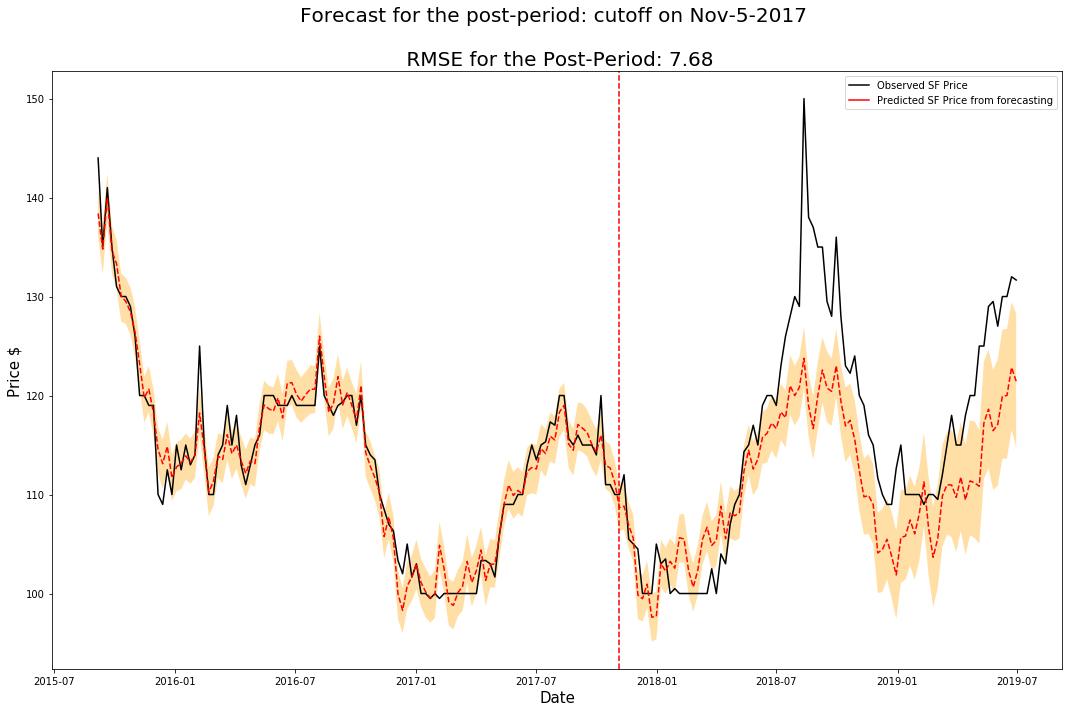

In [17]:
forecast_sf_nov2017, forecast_all_nov2017 = forecast(114,0.05, 0.8)

In [7]:
forecast_sf_nov2017.tail()

,ds,yhat,yhat_lower,yhat_upper
195,2019-06-02,125.101895,97.907351,151.269625
196,2019-06-09,127.631725,99.221081,154.250014
197,2019-06-16,127.649578,98.994294,154.621237
198,2019-06-23,130.257947,100.907122,158.031111
199,2019-06-30,128.877426,98.871427,157.006797


In [8]:
holidays_effect = forecast_all_nov2017[(forecast_all_nov2017['outside lands'] + 
                      forecast_all_nov2017['dreamforce']).abs() >0][['ds','outside lands', 
                        'dreamforce']]

holidays_effect.columns = ['Week', 'Outside Lands', 'Dreamforce']
holidays_effect['Outside Lands'] = holidays_effect['Outside Lands'].round(2)
holidays_effect['Dreamforce'] = holidays_effect['Dreamforce'].round(2)
holidays_effect.reset_index()

,index,Week,Outside Lands,Dreamforce
0,2,2015-09-20,0.00,3.58
1,48,2016-08-07,1.39,0.00
2,57,2016-10-09,0.00,3.58
3,101,2017-08-13,1.39,0.00
4,114,2017-11-12,0.00,3.58
5,153,2018-08-12,1.39,0.00
6,160,2018-09-30,0.00,3.58


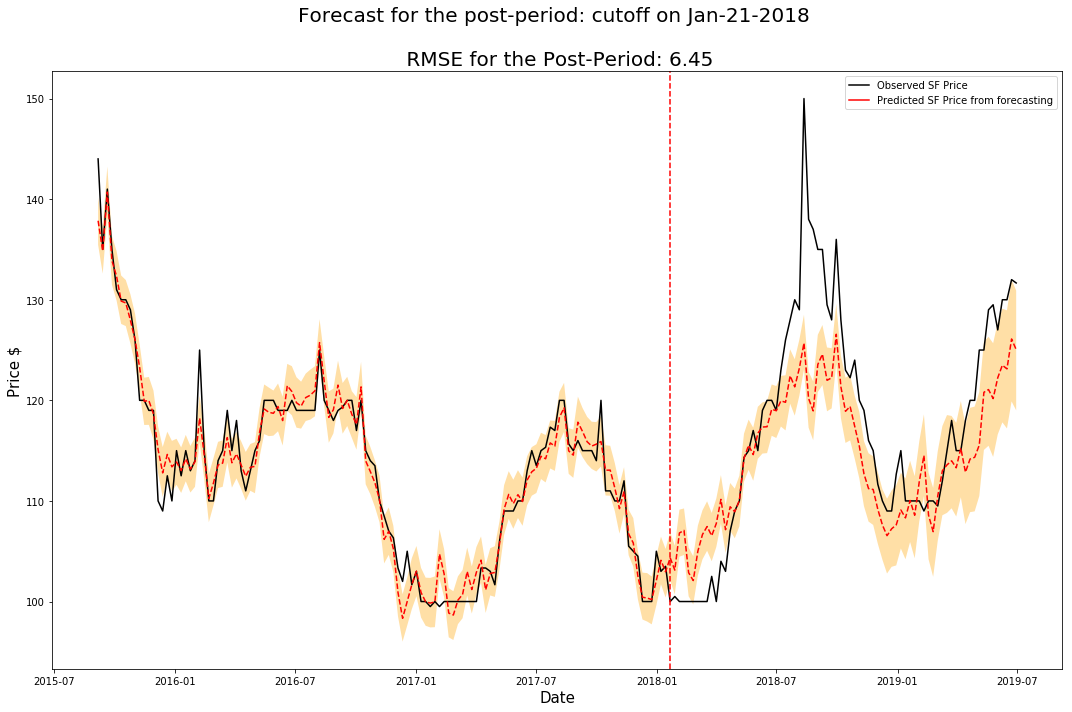

In [18]:
forecast_sf_jan2018, forecast_all_jan2018 = forecast(124,0.05, 1)

In [19]:
def forecast_portland(date_inter):
    
    m = Prophet(changepoint_prior_scale = 0.01, holidays_prior_scale= 0.05, 
                weekly_seasonality = False, daily_seasonality = False, 
                yearly_seasonality = False)
    
    m.add_seasonality(name = 'month', period= 30.5, fourier_order=5)
    m.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
    m.add_seasonality(name = 'quarterly', period = 365.25/4, fourier_order =5)
    
    m.add_country_holidays(country_name = 'US')
    
    m.fit(portland_price[0:date_inter])
    future = m.make_future_dataframe(periods = len(portland_price) - date_inter, freq='W')
    # future['cap'] = 250
    forecast = m.predict(future)

    y_true = portland_price.iloc[date_inter:]['y'].values
    y_pred = forecast.iloc[date_inter:]['yhat'].values
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    rmse = np.round(rmse,2)
 
    
    fig, ax = plt.subplots(1,figsize = (15,10))

    xlinspace = pd.date_range('2015-09-06', periods= portland_price.shape[0], freq='W')

    sns.lineplot(x= 'ds', y='y', color='k', data = portland_price, label = "Observed SF Price")

    sns.lineplot(x = 'ds', y = 'yhat', data = forecast, color = 'r', \
                 label = 'Predicted Portland Price from forecasting')

    ax.lines[1].set_linestyle("--")

    plt.fill_between(forecast['ds'],forecast['yhat_lower'],
                     forecast['yhat_upper'], 
                    facecolor = 'orange',
                    interpolate = 'True',
                    alpha = 0.35)
    
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Price $', fontsize=15)
    if date_inter == 114:
        plt.axvline(x = datetime.date(2017,11,5), color = 'k', linestyle='--')
        plt.title(f"Forecast for the post-period: cutoff on Nov-5-2017 \n \n  RMSE for the Post-Period: {rmse}",fontsize= 20)
    else:
        plt.axvline(x = datetime.date(2018,1,21), color = 'k', linestyle='--')
        plt.title(f"Forecast for the post-period: cutoff on Jan-21-2018 \n \n RMSE for the Post-Period: {rmse}",fontsize=20)
#     a = add_changepoints_to_plot(fig.gca(), m, forecast)
    
#     fig2 = m.plot_components(forecast)
    plt.tight_layout()
    
    forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    forecast_df.to_csv('../data/forecast_portland_median_{}.csv'.format(date_inter))
    
    

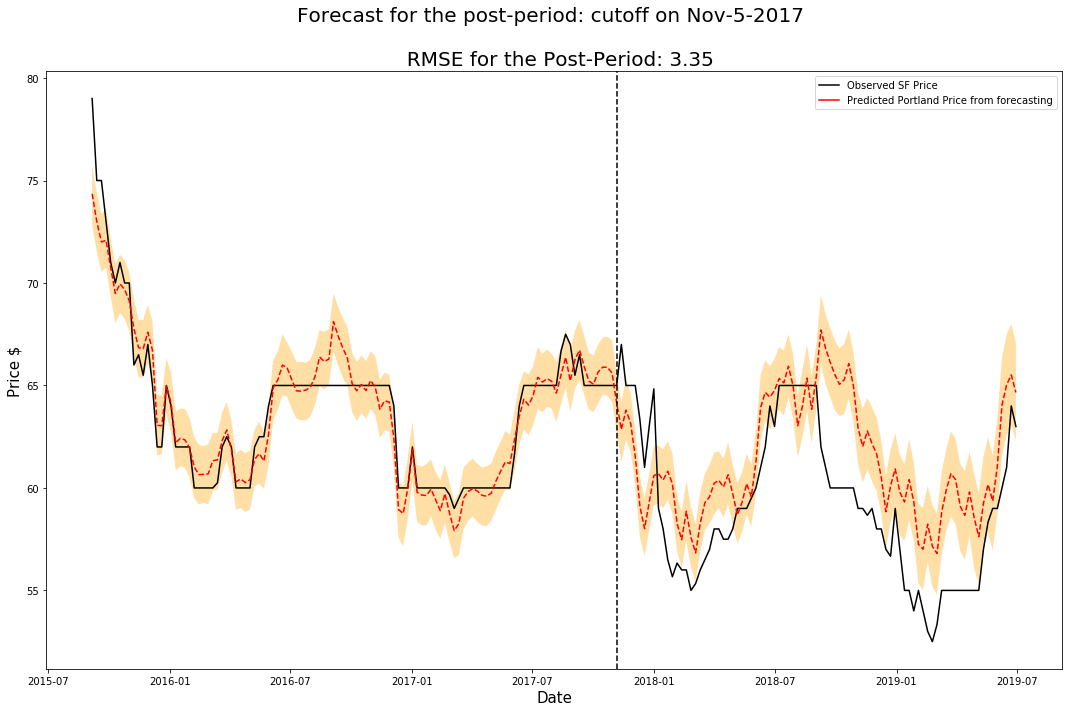

In [20]:
forecast_portland(114)

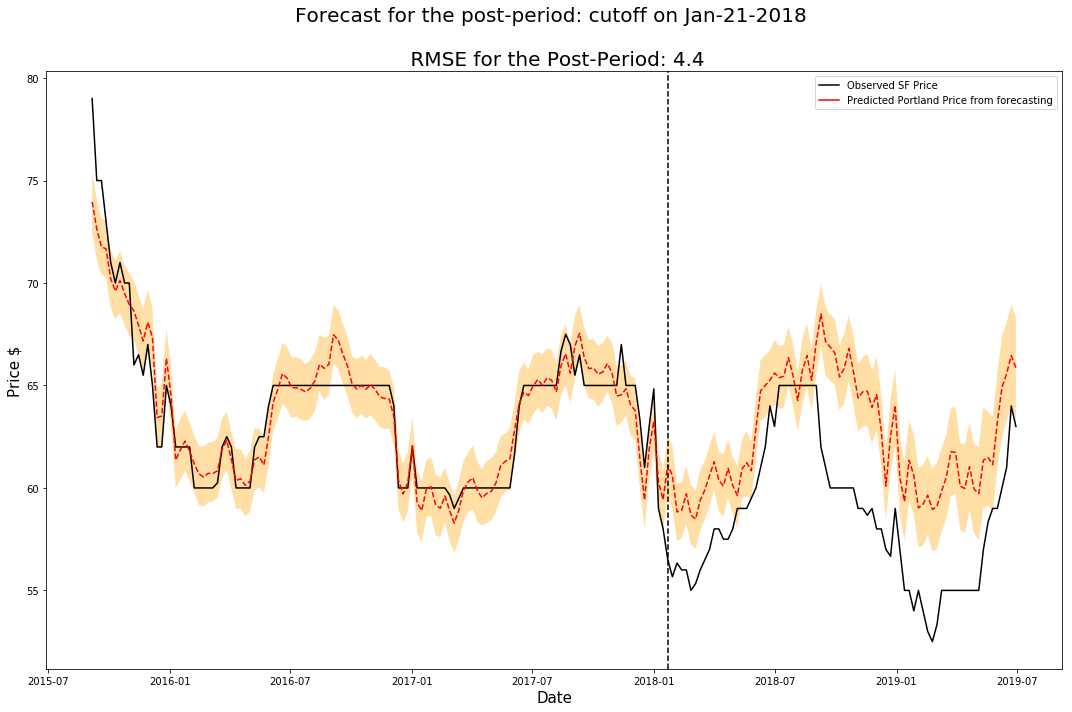

In [21]:
forecast_portland(124)